In [1]:
import numpy as np
import xarray as xr
import dask
import xgcm
import zarr

In [2]:
# Define face_connections for grid object
face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}

### Load dataset

In [3]:
# Main disagnostic output
ds_main = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_datasets/eccov4r3_output')
coords_main = ds_main.coords.to_dataset().reset_coords()
ds_main = ds_main.reset_coords(drop=True)

# Budget terms
ds_budg = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_datasets/eccov4r3_budgets')
coords_budg = ds_budg.coords.to_dataset().reset_coords()
ds_budg = ds_budg.reset_coords(drop=True)

### Volume

In [4]:
# Cell z size
drF = coords_main.drF
rA = coords_main.rA
hFacC = coords_main.hFacC

# Volume (m^3)
vol = (rA*drF*hFacC).transpose('face','k','j','i')

In [5]:
# Scale factor
rstarfac = ((coords_main.Depth + ds_main.ETAN)/coords_main.Depth).transpose('time','face','j','i')

In [6]:
# Salinity
SALT = ds_main.SALT.transpose('time','face','k','j','i')
#SALT = ds_main.SALT.transpose('time','face','k','j','i')*rstarfac

In [7]:
#### Seperate averages and snapshots
ds_ave = ds_main[['ETAN','THETA','SALT','UVELMASS','VVELMASS','WVELMASS',
                  'ADVx_TH','ADVx_SLT','ADVy_TH','ADVy_SLT','ADVr_TH','ADVr_SLT']]

ds_snp = ds_main[['ETAN_snp','THETA_snp','SALT_snp']].rename({'time_snp':'time'})

In [8]:
# Remove oceFWflx from WVELMASS
WVELMASS = ds_main.WVELMASS.transpose('time','face','k_l','j','i')
oceFWflx = ds_main.oceFWflx.assign_coords(k_l=0).expand_dims('k_l').transpose('time','face','k_l','j','i')

rhoconst = 1029
oceFWflx = (oceFWflx/rhoconst)
WVELMASS = xr.concat([WVELMASS.sel(k_l=0) + oceFWflx, WVELMASS[:,:,1:]], 
                     dim='k_l').transpose('time','face','k_l','j','i')

In [9]:
#### Monthly means
ds_ave_clim = ds_ave.groupby('time.month').mean('time')
WVELMASS_clim = WVELMASS.groupby('time.month').mean('time')
SALT_clim = SALT.groupby('time.month').mean('time')
ds_snp_clim = ds_snp.groupby('time.month').mean('time')
ds_budg_clim = ds_budg.groupby('time.month').mean('time')

#### Monthly anomalies
ds_ave_anom = ds_ave.groupby('time.month') - ds_ave_clim
WVELMASS_anom = WVELMASS.groupby('time.month') - WVELMASS_clim
SALT_anom = SALT.groupby('time.month') - SALT_clim
ds_snp_anom = ds_snp.groupby('time.month') - ds_snp_clim
ds_budg_anom = ds_budg.groupby('time.month') - ds_budg_clim

In [10]:
#### Monthly mean terms
grid = xgcm.Grid(ds_ave_clim, face_connections=face_connections)

# Transport
u_clim = (ds_ave_clim.UVELMASS * coords_main.dyG * coords_main.drF).transpose('month','face','k','j','i_g')
v_clim = (ds_ave_clim.VVELMASS * coords_main.dxG * coords_main.drF).transpose('month','face','k','j_g','i')
w_clim = (WVELMASS_clim * coords_main.rA).transpose('month','face','k_l','j','i')

# Potential Temperature (degC)
SALT_clim = SALT_clim.transpose('month','face','k','j','i')
SALT_clim_at_u = grid.interp(SALT_clim, 'X', boundary='extend')
SALT_clim_at_v = grid.interp(SALT_clim, 'Y', boundary='extend')
SALT_clim_at_w = grid.interp(SALT_clim, 'Z', boundary='extend')

In [11]:
hConvV_clim = ds_budg_clim.hConvV
vConvV_clim = ds_budg_clim.vConvV
forcV_clim = ds_budg_clim.forcV

In [12]:
#### Monthly anomaly terms
grid = xgcm.Grid(ds_ave_anom, face_connections=face_connections)

# Transport
u_anom = (ds_ave_anom.UVELMASS * coords_main.dyG * coords_main.drF).transpose('time','face','k','j','i_g')
v_anom = (ds_ave_anom.VVELMASS * coords_main.dxG * coords_main.drF).transpose('time','face','k','j_g','i')
w_anom = (WVELMASS_anom * coords_main.rA).transpose('time','face','k_l','j','i')

# Temperature
SALT_anom = SALT_anom.transpose('time','face','k','j','i')
SALT_anom_at_u = grid.interp(SALT_anom, 'X', boundary='extend')
SALT_anom_at_v = grid.interp(SALT_anom, 'Y', boundary='extend')
SALT_anom_at_w = grid.interp(SALT_anom, 'Z', boundary='extend')

In [13]:
hConvV_anom = ds_budg_anom.hConvV
vConvV_anom = ds_budg_anom.vConvV
forcV_anom = ds_budg_anom.forcV

### Monthly anomaly budget
$$\frac{\partial S^{\prime}}{\partial t} + S^\prime\nabla\overline{\mathbf{u}}^m + \nabla(S^\prime\overline{\mathbf{u}}^m) + \overline{S}^m\nabla\mathbf{u}^\prime + \nabla(\overline{S}^m\mathbf{u}^\prime) + S^\prime\nabla\mathbf{u}^\prime - \overline{S^\prime\nabla\mathbf{u}^\prime}^m + \nabla({\mathbf{u}}^{\prime}\,S^{\prime}-\overline{\mathbf{u}^{\prime}\,S^{\prime}}^m) =  -\nabla\cdot{\mathbf{F_{diff}^{S}}}^{\prime} +  {{F}_\textrm{forc}^S}^\prime + \overline{S^\prime\,{F_\textrm{forc}^V}^\prime}^m - S^\prime{F_\textrm{forc}^V}^\prime - \overline{S}^m {F_\textrm{forc}^V}^\prime - S^\prime\overline{F_\textrm{forc}^V}^m$$

$\frac{\partial S^{\prime}}{\partial t}$

In [14]:
#### Anomaleous tendency
tendSln_anom = ds_budg_anom.tendSln

$-S^\prime\nabla\overline{\mathbf{u}}^m$

In [17]:
adv_Sanom_hConvVclim = SALT_anom.groupby('time.month')*(hConvV_clim + vConvV_clim)*(-1)

$-\nabla(S^\prime\overline{\mathbf{u}}^m)$

In [18]:
#### Mean advection of anomaleous salinity
uclimSanom = u_clim * SALT_anom_at_u.groupby('time.month')
vclimSanom = v_clim * SALT_anom_at_v.groupby('time.month')
wclimSanom = w_clim * SALT_anom_at_w.groupby('time.month')

# Convergence
ADVxy_diff = grid.diff_2d_vector({'X' : uclimSanom, 'Y' : vclimSanom}, boundary = 'fill')
ADVx_diffx = ADVxy_diff['X']
ADVy_diffy = ADVxy_diff['Y']
adv_hConvS = (-(ADVx_diffx + ADVy_diffy)/vol)
adv_vConvS = (grid.diff(wclimSanom, 'Z', boundary='fill')/vol)

adv_ConvS_Uclim_Sanom = adv_hConvS + adv_vConvS

$-\overline{S}^m\nabla\mathbf{u}^\prime$

In [19]:
adv_Sclim_hConvVanom = -SALT_clim*hConvV_anom.groupby('time.month') - SALT_clim*vConvV_anom.groupby('time.month')

$-\nabla(\overline{S}^m\mathbf{u}^\prime)$

In [20]:
#### Anomaleous advection of mean salinity
uanomSclim = u_anom.groupby('time.month') * SALT_clim_at_u
vanomSclim = v_anom.groupby('time.month') * SALT_clim_at_v
wanomSclim = w_anom.groupby('time.month') * SALT_clim_at_w

# Convergence
ADVxy_diff = grid.diff_2d_vector({'X' : uanomSclim, 'Y' : vanomSclim}, boundary = 'fill')
ADVx_diffx = ADVxy_diff['X']
ADVy_diffy = ADVxy_diff['Y']
adv_hConvS = (-(ADVx_diffx + ADVy_diffy)/vol)
adv_vConvS = (grid.diff(wanomSclim, 'Z', boundary='fill')/vol)

adv_ConvS_Uanom_Sclim = adv_hConvS + adv_vConvS

/rigel/home/jt2796/dask/dask/array/core.py:3460: PerformanceWarning: Increasing number of chunks by factor of 24
  **atop_kwargs)
/rigel/home/jt2796/dask/dask/array/core.py:3460: PerformanceWarning: Increasing number of chunks by factor of 24
  **atop_kwargs)
/rigel/home/jt2796/dask/dask/array/core.py:3460: PerformanceWarning: Increasing number of chunks by factor of 24
  **atop_kwargs)
/rigel/home/jt2796/dask/dask/array/core.py:3460: PerformanceWarning: Increasing number of chunks by factor of 24
  **atop_kwargs)
/rigel/home/jt2796/dask/dask/array/core.py:3460: PerformanceWarning: Increasing number of chunks by factor of 24
  **atop_kwargs)
/rigel/home/jt2796/dask/dask/array/core.py:3460: PerformanceWarning: Increasing number of chunks by factor of 24
  **atop_kwargs)
/rigel/home/jt2796/dask/dask/array/core.py:3460: PerformanceWarning: Increasing number of chunks by factor of 24
  **atop_kwargs)
/rigel/home/jt2796/dask/dask/array/core.py:3460: PerformanceWarning: Increasing number of 

$-(S^\prime\nabla\mathbf{u}^\prime$ - $\overline{S^\prime\nabla\mathbf{u}^\prime}^m)$

In [21]:
Sanom_hConvVanom = SALT_anom*(hConvV_anom + vConvV_anom)
Sanom_hConvVanom_clim = Sanom_hConvVanom.groupby('time.month').mean('time')
adv_Sanom_hConvVanom = -(Sanom_hConvVanom.groupby('time.month') - Sanom_hConvVanom_clim)

$-\nabla({\mathbf{u}}^{\prime}\,S^{\prime}-\overline{\mathbf{u}^{\prime}\,S^{\prime}}^m)$

In [22]:
#### Anomaleous advection of anomaleous salinity
uanomSanom = u_anom * SALT_anom_at_u
vanomSanom = v_anom * SALT_anom_at_v
wanomSanom = w_anom * SALT_anom_at_w

uanomSanom_clim = uanomSanom.groupby('time.month').mean('time')
vanomSanom_clim = vanomSanom.groupby('time.month').mean('time')
wanomSanom_clim = wanomSanom.groupby('time.month').mean('time')

uanomSanom_clim_anom = uanomSanom.groupby('time.month') - uanomSanom_clim
vanomSanom_clim_anom = vanomSanom.groupby('time.month') - vanomSanom_clim
wanomSanom_clim_anom = wanomSanom.groupby('time.month') - wanomSanom_clim

# Convergence
ADVxy_diff = grid.diff_2d_vector({'X' : uanomSanom_clim_anom, 'Y' : vanomSanom_clim_anom}, boundary = 'fill')
ADVx_diffx = ADVxy_diff['X']
ADVy_diffy = ADVxy_diff['Y']
adv_hConvS = (-(ADVx_diffx + ADVy_diffy)/vol)
adv_vConvS = (grid.diff(wanomSanom_clim_anom, 'Z', boundary='fill')/vol)

adv_ConvS_Uanom_Sanom = adv_hConvS + adv_vConvS

**Residual** ($R_{\textrm{adv}}^{S}$)
$$-\nabla\cdot F_{\textrm{adv}}^{S} = -S\,(\nabla\cdot\mathbf{u}) - \nabla\cdot(S\mathbf{u}) + R_{\textrm{adv}}^{S}$$

$$\rightarrow R_{\textrm{adv}}^{S} = -\nabla\cdot F_{\textrm{adv}}^{S} + S\,(\nabla\cdot\mathbf{u}) + \nabla\cdot(S\mathbf{u})$$

In [23]:
#### Residual in the advective flux

# Transport
u_transport = (ds_ave.UVELMASS * coords_main.dyG * coords_main.drF)
v_transport = (ds_ave.VVELMASS * coords_main.dxG * coords_main.drF)
w_transport = (WVELMASS * rA)

# Salinity
SALT_at_u = grid.interp(SALT, 'X', boundary='extend')
SALT_at_v = grid.interp(SALT, 'Y', boundary='extend')
SALT_at_w = grid.interp(SALT, 'Z', boundary='extend')

# Advection
uS = (u_transport * SALT_at_u)
vS = (v_transport * SALT_at_v)
wS = (w_transport * SALT_at_w)

# Convergence
ADVxy_diff = grid.diff_2d_vector({'X' : uS, 'Y' : vS}, boundary = 'fill')
ADVx_diffx = ADVxy_diff['X']
ADVy_diffy = ADVxy_diff['Y']
adv_hConvS = (-(ADVx_diffx + ADVy_diffy)/vol).transpose('time','face','k','j','i')
adv_vConvS = (grid.diff(wS, 'Z', boundary='fill')/vol).transpose('time','face','k','j','i')

#adv_hConvSln_true = ((-SALT*hConvV + adv_hConvS_true)/rstarfac).transpose('time','face','k','j','i')
adv_hConvSln = (adv_hConvS - SALT*ds_budg.hConvV).transpose('time','face','k','j','i')
#adv_vConvSln_true = ((-SALT*vConvV + adv_vConvS_true)/rstarfac).transpose('time','face','k','j','i')
adv_vConvSln = (adv_vConvS - SALT*ds_budg.vConvV).transpose('time','face','k','j','i')

# Reconstructed
adv_ConvSln_reco = adv_hConvSln + adv_vConvSln

# True (diagnostic)
adv_ConvSln_true = ds_budg.adv_hConvSln + ds_budg.adv_vConvSln

# Residual
#adv_ConvSln_res = adv_ConvSln_true/rstarfac - adv_ConvSln_reco/rstarfac
adv_ConvSln_res = adv_ConvSln_true - adv_ConvSln_reco

adv_ConvSln_res_clim = adv_ConvSln_res.groupby('time.month').mean('time')
adv_ConvSln_res_anom = adv_ConvSln_res.groupby('time.month') - adv_ConvSln_res_clim

$-\nabla\cdot{\mathbf{F_{diff}^{S}}}^{\prime}$

In [24]:
#### Anomaleous diffusion
dif_hConvSln = ds_budg_anom.dif_hConvSln
dif_vConvSln = ds_budg_anom.dif_vConvSln
dif_ConvSln_anom = dif_hConvSln + dif_vConvSln

${{F}_\textrm{forc}^S}^\prime$

In [25]:
#### Anomaleous forcing
forcS_anom = ds_budg_anom.forcS

$-S^\prime\overline{F_\textrm{forc}^V}^m$

In [26]:
forc_Sanom_Vclim = -forcV_clim*SALT_anom.groupby('time.month')

$-\overline{S}^m {F_\textrm{forc}^V}^\prime$

In [27]:
forc_Sclim_Vanom = -SALT_clim*forcV_anom.groupby('time.month')

$-( S^\prime{F_\textrm{forc}^V}^\prime - \overline{S^\prime\,{F_\textrm{forc}^V}^\prime}^m$)

In [28]:
S_anom_forcV_anom = SALT_anom*forcV_anom
S_anom_forcV_anom_clim = S_anom_forcV_anom.groupby('time.month').mean('time')
forc_Sanom_Vanom = -(S_anom_forcV_anom.groupby('time.month')-S_anom_forcV_anom_clim)

In [29]:
forcSln_anom = ds_budg_anom.forcSln

### Save to zarr

In [30]:
ds = xr.Dataset(data_vars={})
ds['tendSln_anom'] = tendSln_anom
ds['adv_Sanom_hConvVclim'] = adv_Sanom_hConvVclim
ds['adv_ConvS_Uclim_Sanom'] = adv_ConvS_Uclim_Sanom
ds['adv_Sclim_hConvVanom'] = adv_Sclim_hConvVanom
ds['adv_ConvS_Uanom_Sclim'] = adv_ConvS_Uanom_Sclim
ds['adv_Sanom_hConvVanom'] = adv_Sanom_hConvVanom
ds['adv_ConvS_Uanom_Sanom'] = adv_ConvS_Uanom_Sanom
ds['adv_ConvSln_res_anom'] = adv_ConvSln_res_anom
ds['dif_ConvSln_anom'] = dif_ConvSln_anom
ds['forcS_anom'] = forcS_anom
ds['forc_Sanom_Vclim'] = forc_Sanom_Vclim
ds['forc_Sclim_Vanom'] = forc_Sclim_Vanom
ds['forc_Sanom_Vanom'] = forc_Sanom_Vanom
ds['forcSln_anom'] = forcSln_anom

In [31]:
for varname in ds.data_vars:
    ds[varname] = ds[varname].chunk(chunks={'time':1,'face':13,'k':50,'j':90,'i':90})

In [32]:
zarr.blosc.list_compressors()

['blosclz', 'lz4', 'lz4hc', 'snappy', 'zlib', 'zstd']

In [33]:
compressor = zarr.Blosc(cname='zlib')
opts = {}
for varname in ds.data_vars:
    opts[varname] = {'compressor': compressor, 'chunks': (1, 13, 50, 90, 90)}

In [34]:
ds

<xarray.Dataset>
Dimensions:                (face: 13, i: 90, j: 90, k: 50, time: 288)
Coordinates:
  * face                   (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i                      (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
  * j                      (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
  * k                      (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
  * time                   (time) datetime64[ns] 1992-01-15 1992-02-13 ...
    month                  (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 ...
Data variables:
    tendSln_anom           (time, face, k, j, i) float64 dask.array<shape=(288, 13, 50, 90, 90), chunksize=(1, 13, 50, 90, 90)>
    adv_Sanom_hConvVclim   (time, face, k, j, i) float32 dask.array<shape=(288, 13, 50, 90, 90), chunksize=(1, 13, 50, 90, 90)>
    adv_ConvS_Uclim_Sanom  (time, face, k, j, i) float32 dask.array<shape=(288, 13, 50, 90, 90), chunksize=(1, 13, 50, 90, 90)>
    adv_Sclim_hConvVanom   (time, face

In [35]:
from dask.diagnostics import ProgressBar

In [36]:
with ProgressBar():
    ds.to_zarr('/rigel/ocp/users/jt2796/eccov4r3_sln_budget_anom', encoding=opts)

[                                        ] | 0% Completed |  5min 10.8s

/rigel/home/jt2796/dask/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/rigel/home/jt2796/dask/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[                                        ] | 1% Completed |  9min  4.5s

/rigel/home/jt2796/dask/dask/local.py:255: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


[#                                       ] | 3% Completed | 10min  9.2s

/rigel/home/jt2796/dask/dask/local.py:255: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)


[##############                          ] | 36% Completed | 36min 47.9s

/rigel/home/jt2796/dask/dask/local.py:255: RuntimeWarning: invalid value encountered in multiply
  return func(*args2)


[##############                          ] | 37% Completed | 36min 54.3s

/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


[########################################] | 100% Completed |  1hr 26min 20.4s


### Check

In [37]:
ds_budgSln_anom = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_sln_budget_anom')

In [38]:
ds_budgSln_anom

<xarray.Dataset>
Dimensions:                (face: 13, i: 90, j: 90, k: 50, time: 288)
Coordinates:
  * face                   (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i                      (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
  * j                      (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
  * k                      (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
    month                  (time) int64 dask.array<shape=(288,), chunksize=(288,)>
  * time                   (time) datetime64[ns] 1992-01-15 1992-02-13 ...
Data variables:
    adv_ConvS_Uanom_Sanom  (time, face, k, j, i) float32 dask.array<shape=(288, 13, 50, 90, 90), chunksize=(1, 13, 50, 90, 90)>
    adv_ConvS_Uanom_Sclim  (time, face, k, j, i) float32 dask.array<shape=(288, 13, 50, 90, 90), chunksize=(1, 13, 50, 90, 90)>
    adv_ConvS_Uclim_Sanom  (time, face, k, j, i) float32 dask.array<shape=(288, 13, 50, 90, 90), chunksize=(1, 13, 50, 90, 90)>
    adv_ConvSln_res_anom   (time, fa

In [39]:
ds_budgSln_anom.adv_ConvSln_res_anom[1,:,1]

<xarray.DataArray 'adv_ConvSln_res_anom' (face: 13, j: 90, i: 90)>
dask.array<shape=(13, 90, 90), dtype=float32, chunksize=(13, 90, 90)>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    k        int64 1
    month    int64 dask.array<shape=(), chunksize=()>
    time     datetime64[ns] 1992-02-13

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
def quick_llc_plot(data, axis_off=False, **kwargs):
    face_to_axis = {0: (2, 0), 1: (1, 0), 2: (0, 0),
                    3: (2, 1), 4: (1, 1), 5: (0, 1),
                    7: (0, 2), 8: (1, 2), 9: (2, 2),
                    10: (0, 3), 11: (1, 3), 12: (2, 3)}
    transpose = [7, 8, 9, 10, 11, 12]
    gridspec_kw = dict(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    fig, axes = plt.subplots(nrows=3, ncols=4, gridspec_kw=gridspec_kw, figsize=(10,4))
    for face, (j, i) in face_to_axis.items():
        data_ax = data.sel(face=face)
        ax = axes[j,i]
        yincrease = True
        if face in transpose:
            data_ax = data_ax.transpose()
            yincrease = False
        p = data_ax.plot(ax=ax, yincrease=yincrease, **kwargs)
        #p = data_ax.plot(ax=ax, **kwargs)
        if axis_off:
            ax.axis('off')
        ax.set_title('')
    # use implicit way
    cbar = fig.colorbar(p, ax=axes.ravel().tolist(), shrink=0.95)

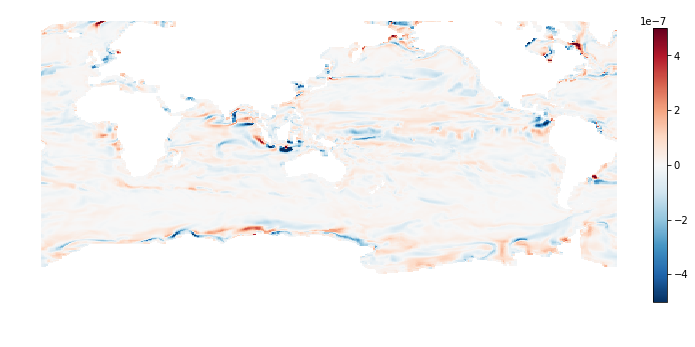

In [14]:
quick_llc_plot(ds_budgSln_anom.adv_ConvSln_res_anom[1,:,0], add_colorbar=False, axis_off=True, 
               cmap='RdBu_r',vmin=-5e-7,vmax=5e-7)

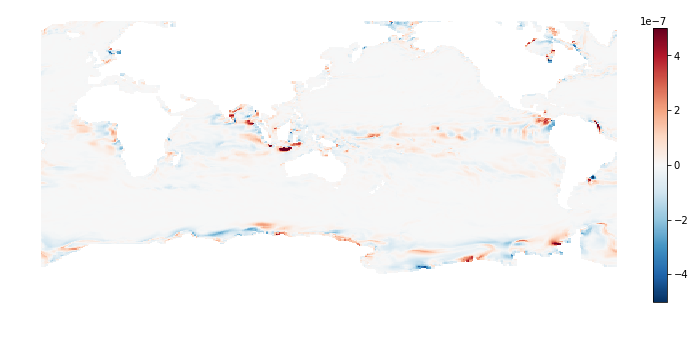

In [15]:
quick_llc_plot(ds_budgSln_anom.adv_ConvSln_res_anom[1,:,1], add_colorbar=False, axis_off=True, 
               cmap='RdBu_r',vmin=-5e-7,vmax=5e-7)

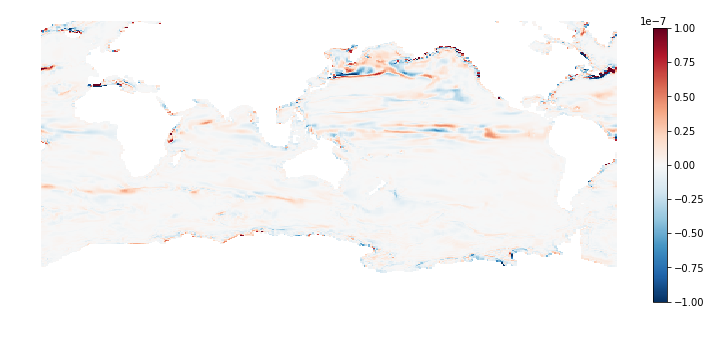

In [16]:
quick_llc_plot(ds_budgSln_anom.adv_ConvSln_res_anom[1,:,10], add_colorbar=False, axis_off=True, 
               cmap='RdBu_r',vmin=-1e-7,vmax=1e-7)

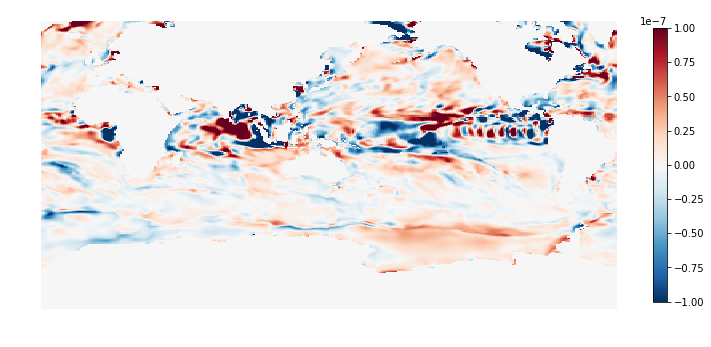

In [67]:
quick_llc_plot(ds_budgSln_anom.tendSln_anom[-2,:,0], add_colorbar=False, axis_off=True, 
               cmap='RdBu_r',vmin=-1e-7,vmax=1e-7)

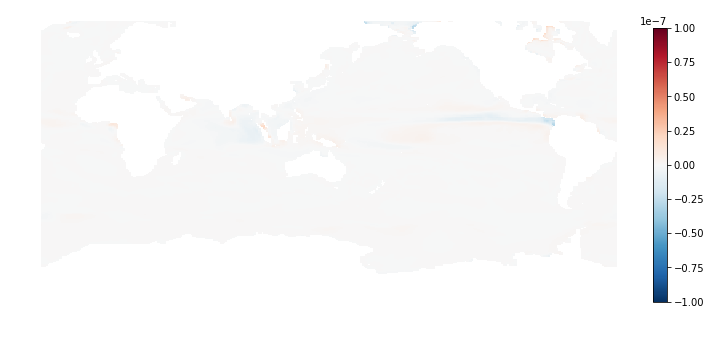

In [69]:
quick_llc_plot(ds_budgSln_anom.adv_Sanom_hConvVclim[-2,:,0], add_colorbar=False, axis_off=True, 
               cmap='RdBu_r',vmin=-1e-7,vmax=1e-7)

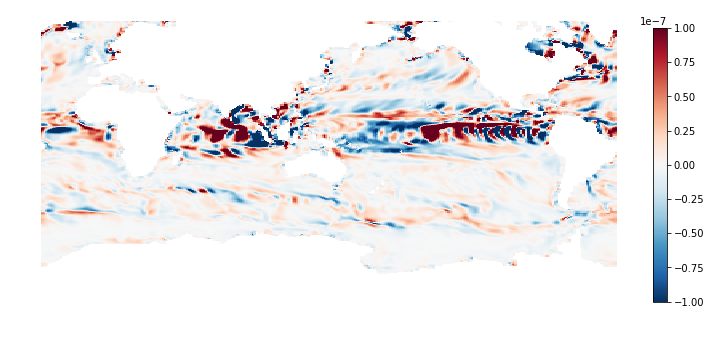

In [70]:
quick_llc_plot(ds_budgSln_anom.adv_ConvS_Uclim_Sanom[-2,:,0], add_colorbar=False, axis_off=True, 
               cmap='RdBu_r',vmin=-1e-7,vmax=1e-7)

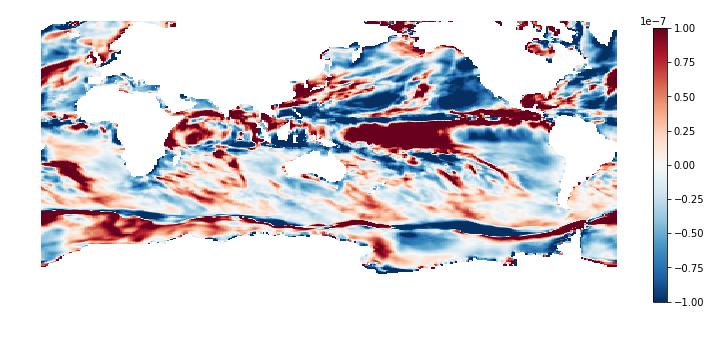

In [71]:
quick_llc_plot(ds_budgSln_anom.adv_Sclim_hConvVanom[-2,:,0], add_colorbar=False, axis_off=True, 
               cmap='RdBu_r',vmin=-1e-7,vmax=1e-7)

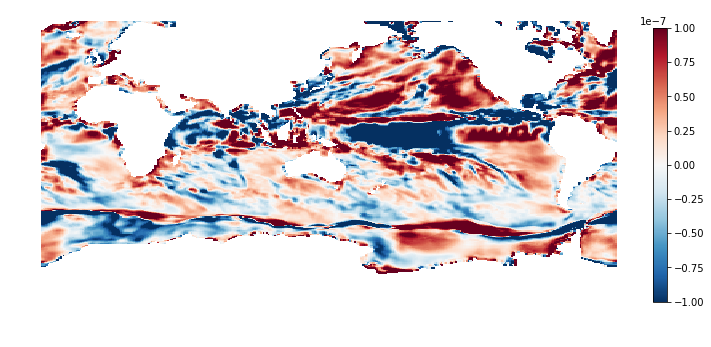

In [72]:
quick_llc_plot(ds_budgSln_anom.adv_ConvS_Uanom_Sclim[-2,:,0], add_colorbar=False, axis_off=True, 
               cmap='RdBu_r',vmin=-1e-7,vmax=1e-7)

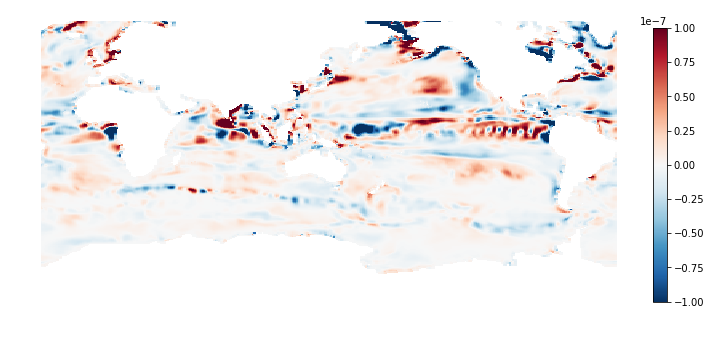

In [74]:
quick_llc_plot(ds_budgSln_anom.adv_Sclim_hConvVanom[-2,:,0]+ds_budgSln_anom.adv_ConvS_Uanom_Sclim[-2,:,0],
               add_colorbar=False, axis_off=True, cmap='RdBu_r',vmin=-1e-7,vmax=1e-7)

### Plot time series

In [42]:
f = 1
k = 0
j = 10
i = 10

In [43]:
results = dask.compute(ds_budgSln_anom.tendSln_anom[:,f,k,j,i],
                       ds_budgSln_anom.adv_Sanom_hConvVclim[:,f,k,j,i],
                       ds_budgSln_anom.adv_ConvS_Uclim_Sanom[:,f,k,j,i],
                       ds_budgSln_anom.adv_Sclim_hConvVanom[:,f,k,j,i],
                       ds_budgSln_anom.adv_ConvS_Uanom_Sclim[:,f,k,j,i],
                       ds_budgSln_anom.adv_Sanom_hConvVanom[:,f,k,j,i],
                       ds_budgSln_anom.adv_ConvS_Uanom_Sanom[:,f,k,j,i],
                       ds_budgSln_anom.adv_ConvSln_res_anom[:,f,k,j,i],
                       ds_budgSln_anom.dif_ConvSln_anom[:,f,k,j,i],
                       ds_budgSln_anom.forcS_anom[:,f,k,j,i],
                       ds_budgSln_anom.forc_Sanom_Vclim[:,f,k,j,i],
                       ds_budgSln_anom.forc_Sclim_Vanom[:,f,k,j,i],
                       ds_budgSln_anom.forc_Sanom_Vanom[:,f,k,j,i],
                       ds_budgSln_anom.forcSln_anom[:,f,k,j,i])

In [45]:
total = results[9] + results[10] + results[11] + results[12]

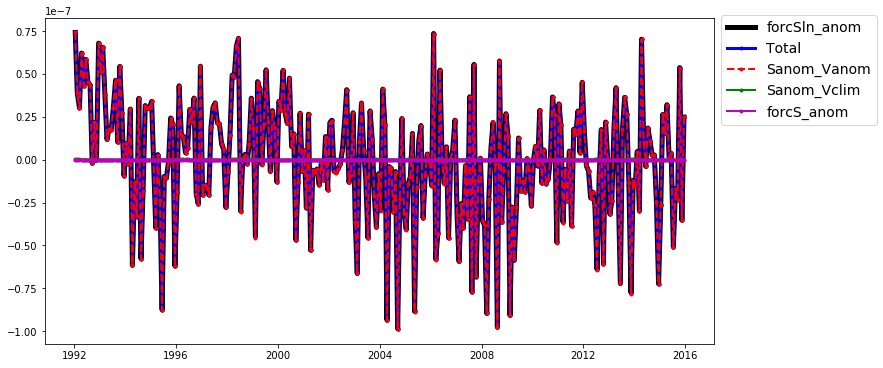

In [46]:
plt.figure(figsize=(12,6))
plt.plot(results[13].time, results[13], lw=5, color='k', marker='.',label='forcSln_anom')
plt.plot(total.time, total, lw=3, color='b', marker='.',label='Total')
plt.plot(results[11].time, results[11], lw=2, color='r',linestyle='--', marker='.',label='Sanom_Vanom')
plt.plot(results[10].time, results[10], lw=2, color='g', marker='.',label='Sanom_Vclim')
plt.plot(results[9].time, results[9], lw=2, color='m', marker='.',label='forcS_anom')

plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

In [47]:
total = results[1] + results[2] + results[3] + results[4] + results[5] + results[6] + results[7]

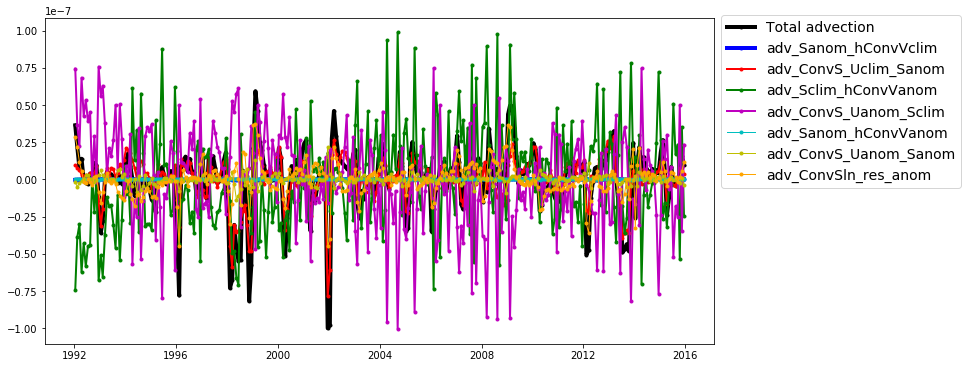

In [50]:
plt.figure(figsize=(12,6))

plt.plot(total.time, total, lw=4, color='k', marker='.',label='Total advection')
plt.plot(results[1].time, results[1], lw=4, color='b', marker='.',label='adv_Sanom_hConvVclim')
plt.plot(results[2].time, results[2], lw=2, color='r', marker='.',label='adv_ConvS_Uclim_Sanom')
plt.plot(results[3].time, results[3], lw=2, color='g', marker='.',label='adv_Sclim_hConvVanom')
plt.plot(results[4].time, results[4], lw=2, color='m', marker='.',label='adv_ConvS_Uanom_Sclim')
plt.plot(results[5].time, results[5], lw=1, color='c', marker='.',label='adv_Sanom_hConvVanom')
plt.plot(results[6].time, results[6], lw=1, color='y', marker='.',label='adv_ConvS_Uanom_Sanom')
plt.plot(results[7].time, results[7], lw=1, color='orange', marker='.',label='adv_ConvSln_res_anom')

plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

In [51]:
results = dask.compute(ds_budgSln_anom.tendSln_anom[:,f,k,j,i],
                    ds_budgSln_anom.adv_Sanom_hConvVclim[:,f,k,j,i]+ds_budgSln_anom.adv_ConvS_Uclim_Sanom[:,f,k,j,i], 
                    ds_budgSln_anom.adv_Sclim_hConvVanom[:,f,k,j,i]+ds_budgSln_anom.adv_ConvS_Uanom_Sclim[:,f,k,j,i],
                    ds_budgSln_anom.adv_Sanom_hConvVanom[:,f,k,j,i]+ds_budgSln_anom.adv_ConvS_Uanom_Sanom[:,f,k,j,i],
                    ds_budgSln_anom.adv_ConvSln_res_anom[:,f,k,j,i],
                    ds_budgSln_anom.dif_ConvSln_anom[:,f,k,j,i],
                    ds_budgSln_anom.forcS_anom[:,f,k,j,i]+ds_budgSln_anom.forc_Sanom_Vclim[:,f,k,j,i]+\
                    ds_budgSln_anom.forc_Sclim_Vanom[:,f,k,j,i]+ds_budgSln_anom.forc_Sanom_Vanom[:,f,k,j,i])

$$\frac{\partial S^{\prime}}{\partial t} + S^\prime\nabla\overline{\mathbf{u}}^m + \nabla(S^\prime\overline{\mathbf{u}}^m) + \overline{S}^m\nabla\mathbf{u}^\prime + \nabla(\overline{S}^m\mathbf{u}^\prime) + S^\prime\nabla\mathbf{u}^\prime - \overline{S^\prime\nabla\mathbf{u}^\prime}^m + \nabla({\mathbf{u}}^{\prime}\,S^{\prime}-\overline{\mathbf{u}^{\prime}\,S^{\prime}}^m) =  -\nabla\cdot{\mathbf{F_{diff}^{S}}}^{\prime} +  {{F}_\textrm{forc}^S}^\prime + \overline{S^\prime\,{F_\textrm{forc}^V}^\prime}^m - S^\prime{F_\textrm{forc}^V}^\prime - \overline{S}^m {F_\textrm{forc}^V}^\prime - S^\prime\overline{F_\textrm{forc}^V}^m$$

- `results[0]`: Anomaleous tendency ($\frac{\partial S^{\prime}}{\partial t}$)
- `results[1]`: $-S^\prime\nabla\overline{\mathbf{u}}^m - \nabla(S^\prime\overline{\mathbf{u}}^m)$
- `results[2]`: $-\overline{S}^m\nabla\mathbf{u}^\prime - \nabla(\overline{S}^m\mathbf{u}^\prime)$
- `results[3]`: $-(S^\prime\nabla\mathbf{u}^\prime-\overline{S^\prime\nabla\mathbf{u}^\prime}^m) - \nabla({\mathbf{u}}^{\prime}\,S^{\prime}-\overline{\mathbf{u}^{\prime}\,S^{\prime}}^m)$
- `results[4]`: Residual in the advective convergence
- `results[5]`: $-\nabla \cdot {\bf{F_{diff}}}^{\prime}$
- `results[6]`: ${{F}_\textrm{forc}^S}^\prime + \overline{S^\prime\,{F_\textrm{forc}^V}^\prime}^m - S^\prime{F_\textrm{forc}^V}^\prime - \overline{S}^m {F_\textrm{forc}^V}^\prime - S^\prime\overline{F_\textrm{forc}^V}^m$

In [52]:
total = results[1] + results[2] + results[3] + results[4] + results[5] + results[6]

In [53]:
ds_budgSln_anom2 = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_sln_budget_anom_new3/')

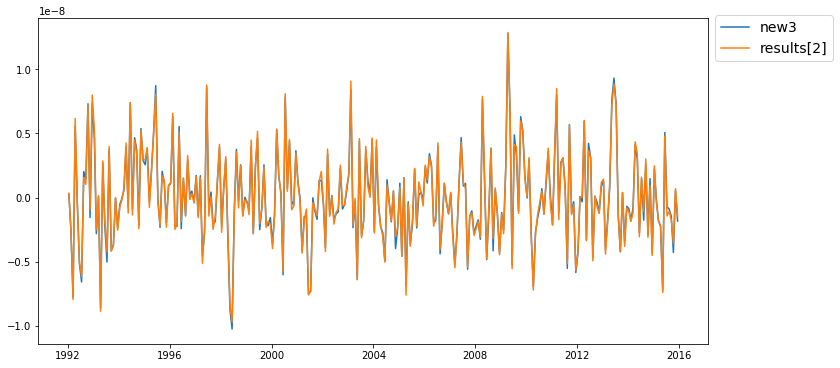

In [54]:
plt.figure(figsize=(12,6))

plt.plot(ds_budgSln_anom2.time, ds_budgSln_anom2.adv_ConvSln_Uanom_Sclim[:,f,k,j,i], label=r'new3')
plt.plot(results[2].time, results[2], label=r'results[2]')

#plt.plot(ds_budgSln_anom2.time, ds_budgSln_anom2.adv_ConvSln_Uclim_Sanom[:,f,k,j,i], label=r'new3')
#plt.plot(results[1].time, results[1], label=r'results[1]')

#plt.plot(ds_budgSln_anom2.time, ds_budgSln_anom2.forcSln_anom[:,f,k,j,i], label=r'new3')
#plt.plot(results[6].time, results[6], label=r'results[6]')

#plt.plot(ds_budgSln_anom2.time, ds_budgSln_anom2.adv_ConvSln_Uanom_Sanom[:,f,k,j,i], label=r'new3')
#plt.plot(results[3].time, results[3], label=r'results[3]')
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))


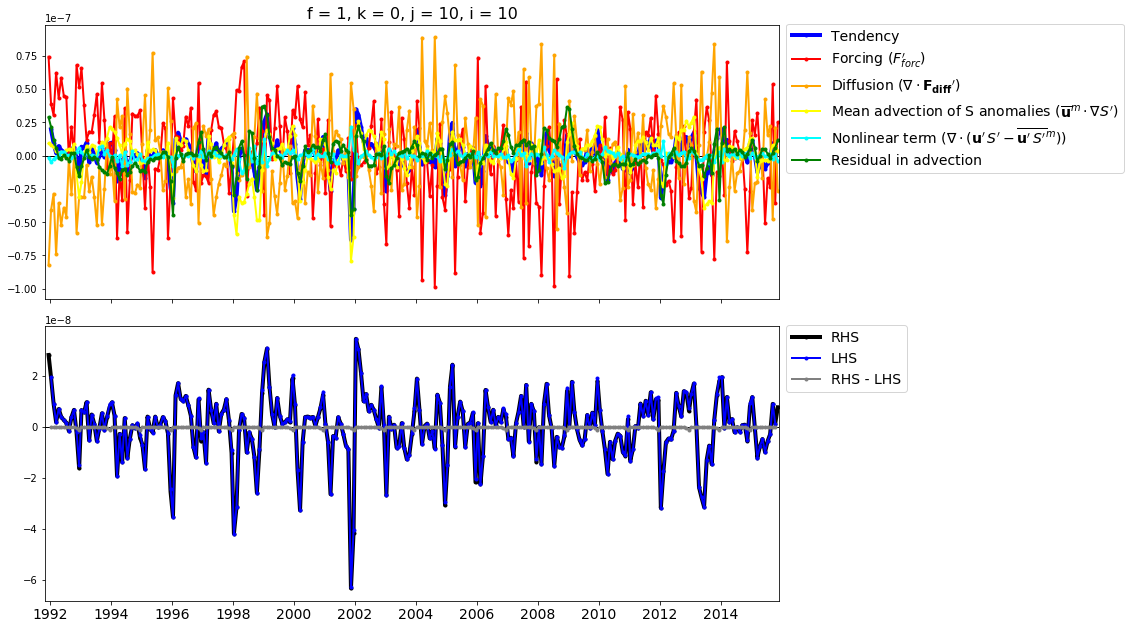

In [55]:
fig, axes = plt.subplots(2, 1,figsize=(17,10))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.title('f = %s, k = %s, j = %s, i = %s' % (f,k,j,i), fontsize=16)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time, results[0], lw=4, color='blue', marker='.',label='Tendency')
plt.plot(results[6].time, results[6], lw=2, color='red', marker='.',
         label=r'Forcing ($F_{forc}^{\prime}$)')
plt.plot(results[5].time, results[5], lw=2, color='orange', marker='.',
         label=r'Diffusion ($\nabla \cdot {\mathbf{F_{diff}}}^{\prime}$)')
plt.plot(results[1].time, results[1], lw=2, color='yellow', marker='.',
         label=r'Mean advection of S anomalies ($\overline{\mathbf{u}}^m\cdot\nabla S^{\prime}$)')
#plt.plot(results[2].time, results[2], lw=2, color='purple', marker='.',
#         label=r'Anomaleous advection of mean S ($\mathbf{u}^{\prime} \cdot \overline{\nabla S}^m$)')
plt.plot(results[3].time, results[3], lw=2, color='cyan', marker='.',
         label=r'Nonlinear term ($\nabla \cdot ({\mathbf{u}}^{\prime}\,S^{\prime}-\overline{\mathbf{u}^{\prime}\,S^{\prime}}^m)$)')
plt.plot(results[4].time, results[4], lw=2, color='green', marker='.',label='Residual in advection')
#plt.xlim([ds_budgH_anom.time.values[0],ds_budgH_anom.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'))
#plt.yticks(np.arange(-4e-7,6e-7,2.0e-7),fontsize=14)
plt.setp(plt.gca(), 'xticklabels',[])
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

plt.subplot(2, 1, 2)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(total.time, total, lw=4, color='k', marker='.',label='RHS')
plt.plot(results[0].time, results[0], lw=2, color='blue', marker='.',label='LHS')
plt.plot(results[0].time, total-results[0], lw=2, color='grey', marker='.',label='RHS - LHS')
#plt.xlim([ds_budgH_anom.time.values[0],ds_budgH_anom.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'),fontsize=14)
#plt.yticks(np.arange(-4e-7,6e-7,2.0e-7),fontsize=14)

plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

fig.subplots_adjust(left=0.1, right=0.7, bottom=0.1, top=0.9)

#plt.savefig('/rigel/home/jt2796/tmp/figure.png')
plt.show()

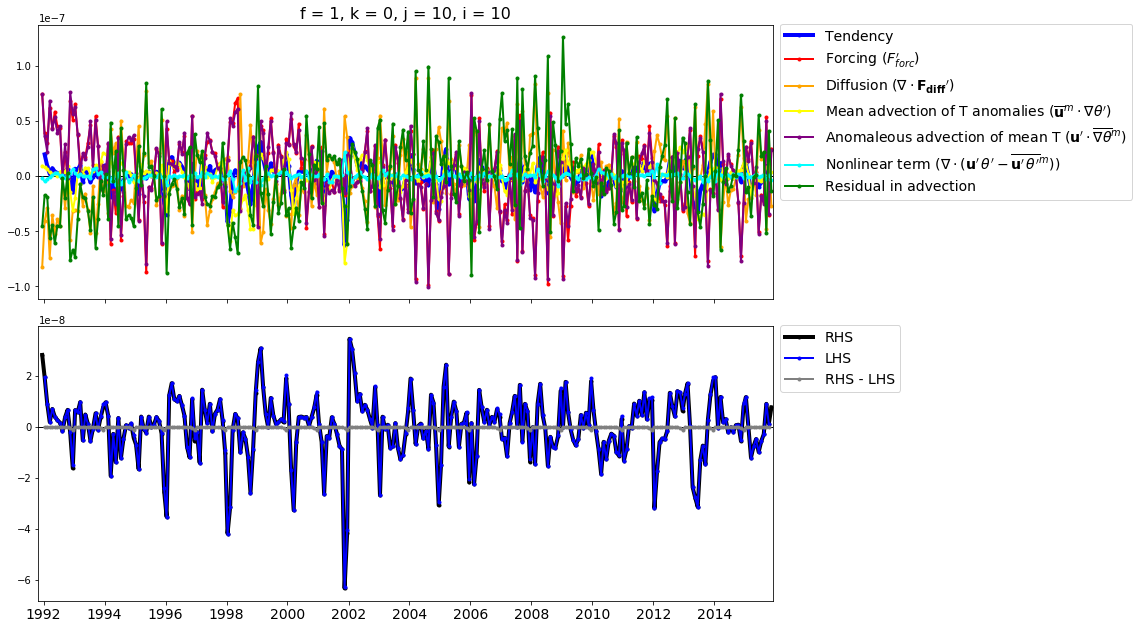

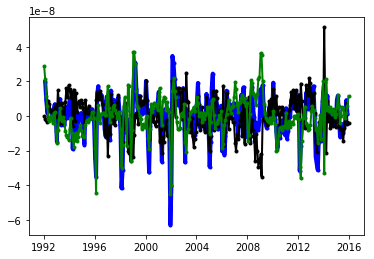

In [50]:
plt.plot(results[0].time, results[0], lw=4, color='blue', marker='.')
plt.plot(results[1].time, results[1]+results[2]+results[3]+results[4]+results[5], lw=2, color='k', marker='.')
plt.plot(results[6].time, results[6], lw=2, color='g', marker='.')

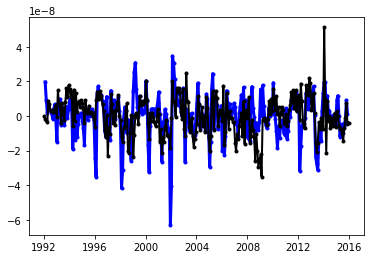

In [52]:
plt.plot(results[0].time, results[0], lw=3, color='blue', marker='.')
plt.plot(results[1].time, results[1]+results[2]+results[3]+results[4]+results[5], lw=2, color='k', marker='.')

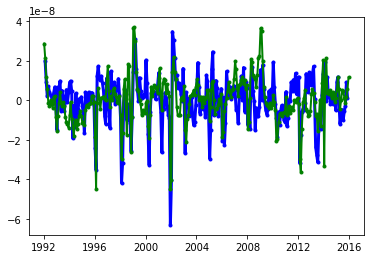

In [41]:
plt.plot(results[0].time, results[0], lw=3, color='blue', marker='.')
plt.plot(results[6].time, results[6], lw=2, color='g', marker='.')

(730089.0, 733773.0)

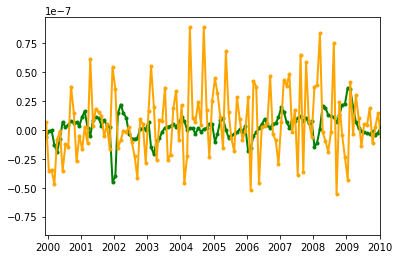

In [42]:
plt.plot(results[6].time, results[6], lw=2, color='g', marker='.')
plt.plot(results[2].time, results[2], lw=2, color='orange', marker='.',label='Tendency')
plt.xlim(['1999-12-01','2010-01-01'])

(730089.0, 733773.0)

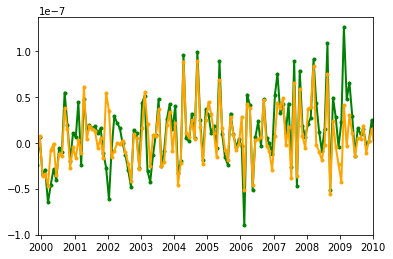

(730089.0, 733773.0)

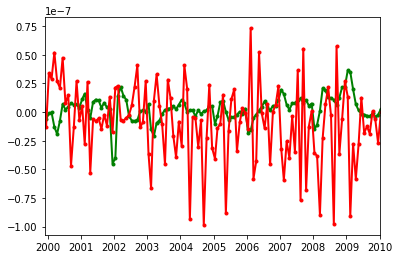

In [43]:
plt.plot(results[6].time, results[6], lw=2, color='g', marker='.')
plt.plot(results[1].time, results[1], lw=2, color='r', marker='.',label='Tendency')
plt.xlim(['1999-12-01','2010-01-01'])

(730089.0, 733773.0)

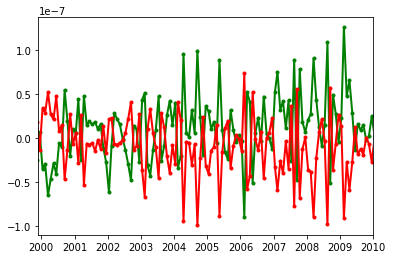

(730089.0, 733773.0)

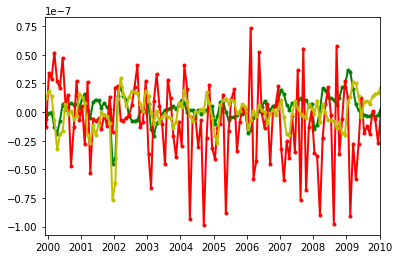

In [44]:
plt.plot(results[6].time, results[6], lw=2, color='g', marker='.')
plt.plot(results[1].time, results[1], lw=2, color='r', marker='.',label='Tendency')

plt.plot(results[3].time, results[3]+results[4], lw=2, color='y', marker='.')
#plt.plot(results[4].time, results[4], lw=2, color='purple', marker='.',label='Tendency')
plt.xlim(['1999-12-01','2010-01-01'])

(730089.0, 733773.0)

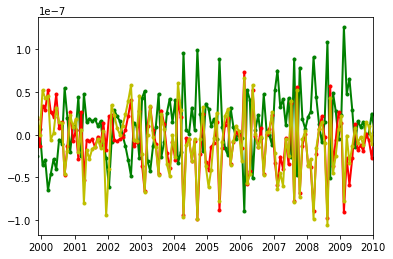

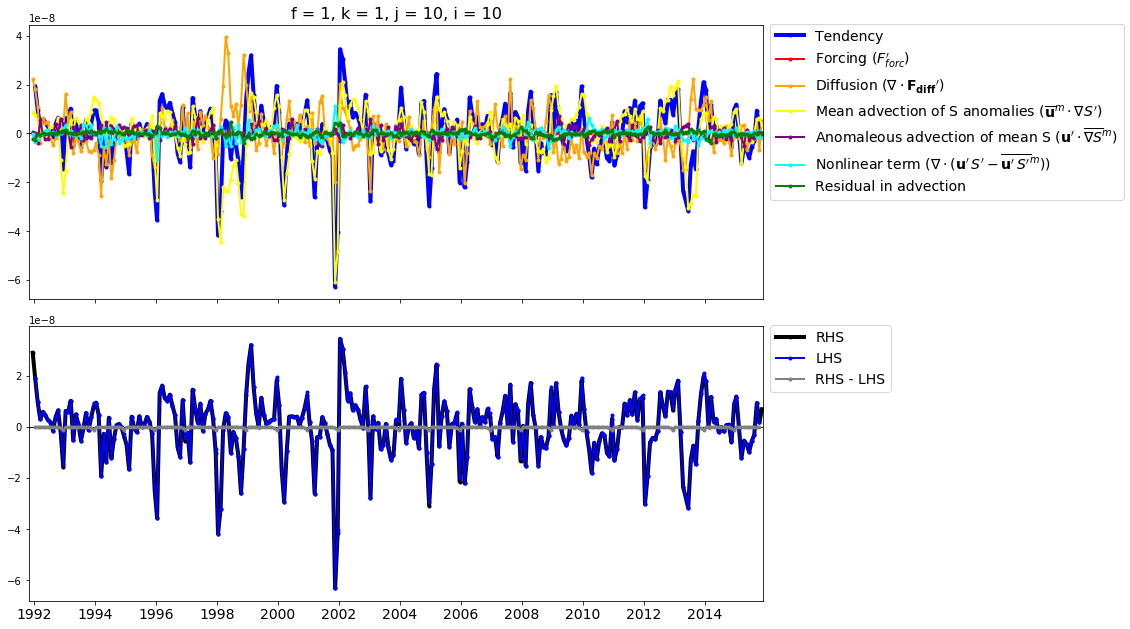

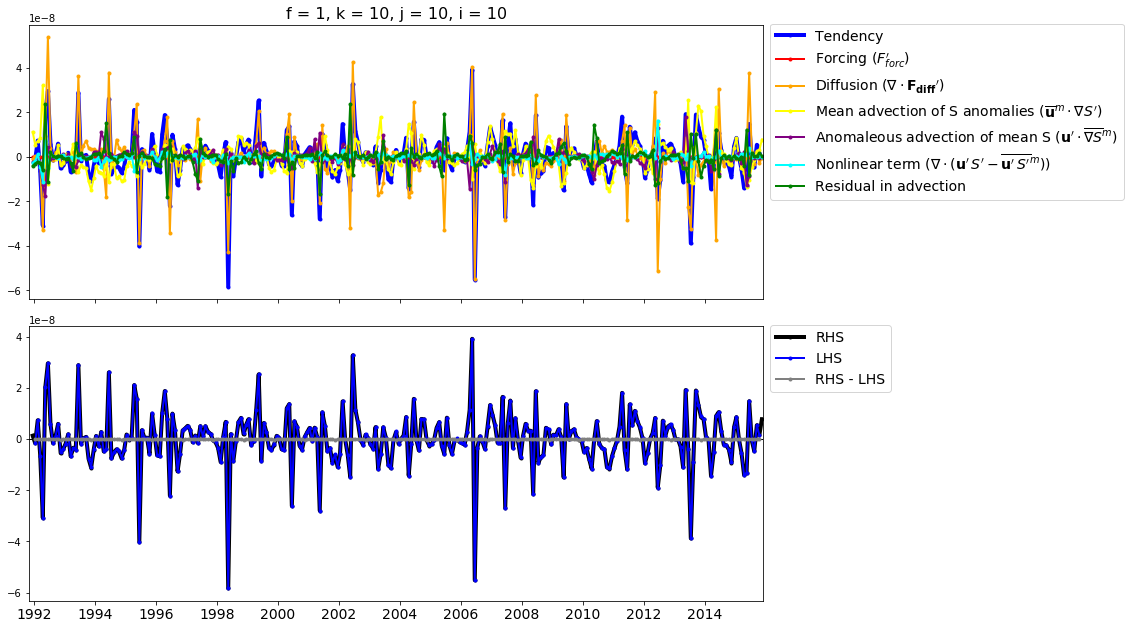

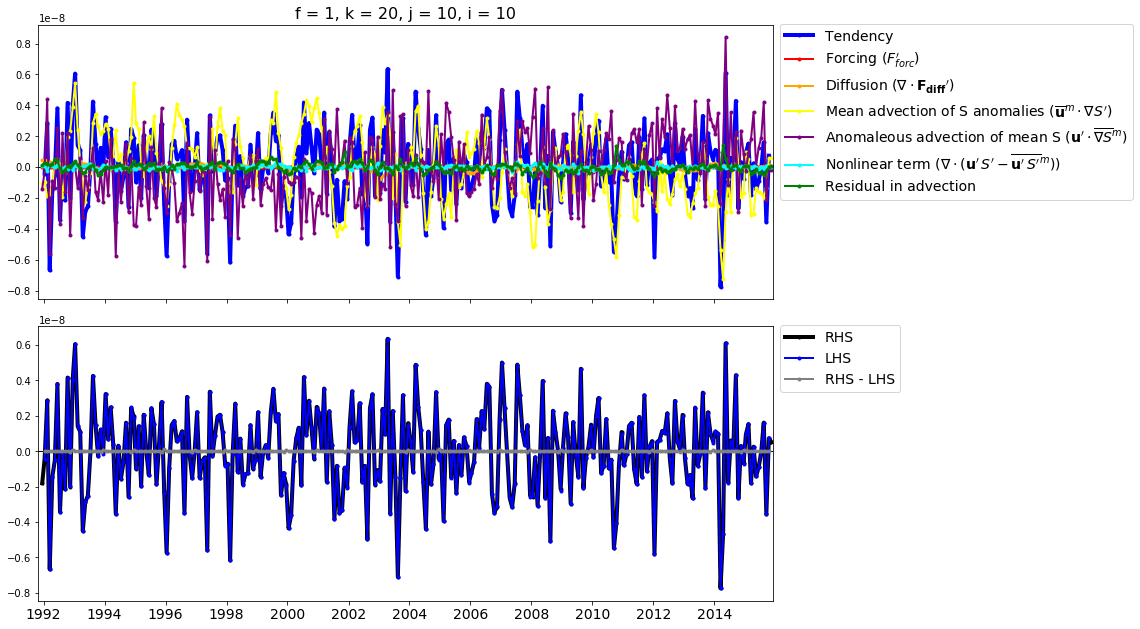

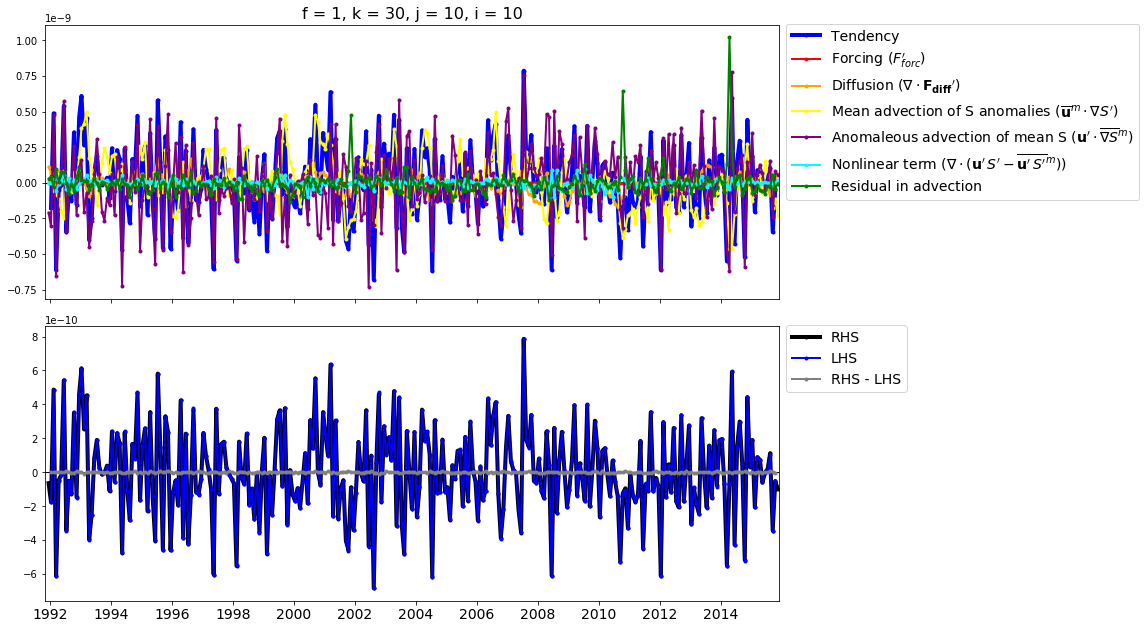

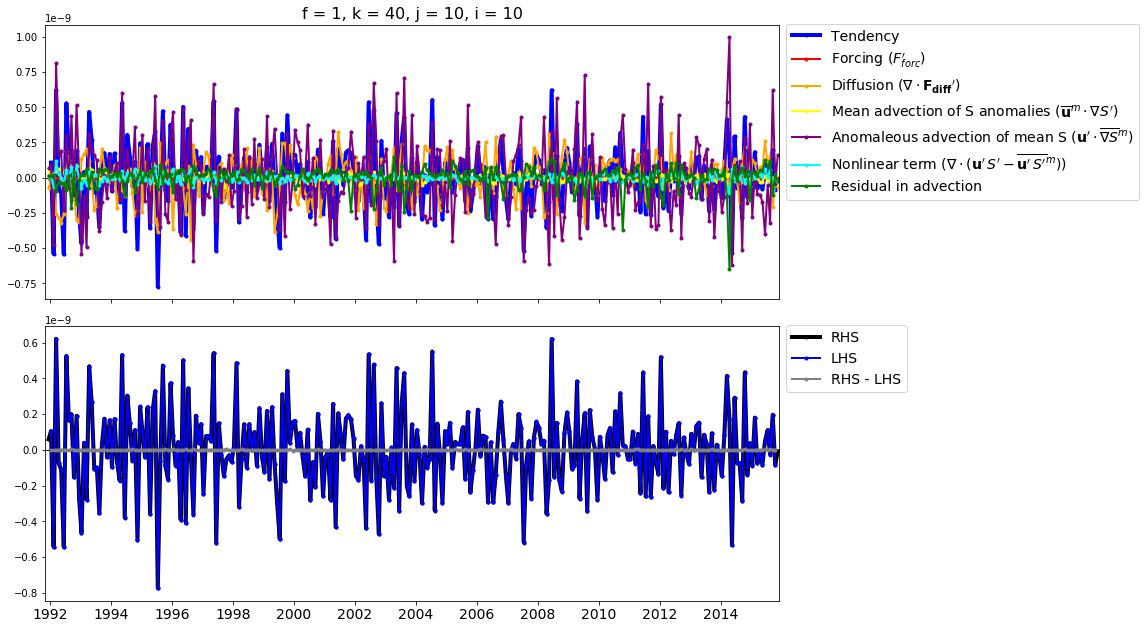

In [40]:
import pandas as pd
from scipy import stats
from scipy.stats.stats import pearsonr

In [41]:
df = pd.DataFrame({'Tendency':results[0].isel(time=slice(1, -1)),'Forcing':results[1].isel(time=slice(1, -1)),
                   'Diffusion':results[2].isel(time=slice(1, -1)),'ubarSanom':results[3].isel(time=slice(1, -1)),
                   'uanomSbar':results[4].isel(time=slice(1, -1)),'Nonlinear':results[5].isel(time=slice(1, -1)),
                   'Residual':results[6].isel(time=slice(1, -1))})

In [42]:
# k=0
for col in list(df):
    var = np.var(df.Tendency,ddof=1)
    cov = np.cov(df[col], df.Tendency)[0][1]
    ratio = cov/var
    print (col, '%.2f' % ratio)

Tendency 1.00
Forcing 0.73
Diffusion -1.10
ubarSanom 0.91
uanomSbar -0.06
Nonlinear -0.01
Residual 0.55


Tendency 1.00
Forcing 0.73
Diffusion -1.10
ubarSanom 0.91
uanomSbar -0.06
Nonlinear -0.01
Residual 0.55


Tendency 1.00
Forcing 0.73
Diffusion -1.10
ubarSanom 0.91
uanomSbar -0.06
Nonlinear -0.01
Residual 0.55


In [109]:
0.73-1.10+0.91-0.06-0.01+0.55

1.02

In [116]:
# k=1

Tendency 1.00
Forcing 0.00
Diffusion 0.32
ubarSanom 0.73
uanomSbar -0.02
Nonlinear 0.00
Residual -0.03


In [117]:
0.00+0.32+0.73-0.02+0.00-0.03

1.0

In [122]:
# k=10

Tendency 1.00
Forcing 0.00
Diffusion 0.83
ubarSanom 0.06
uanomSbar 0.05
Nonlinear 0.02
Residual 0.04


In [123]:
0.00+0.83+0.06+0.05+0.02+0.04

1.0

In [22]:
# k=20

Tendency 1.00000
Forcing 0.00000
Diffusion 0.08572
ubarTanom 0.60005
uanomTbar 0.13479
Nonlinear 0.02497
Residual 0.15448


In [23]:
0+0.08572+0.60005+0.13479+0.02497+0.15448

1.00001

In [75]:
# k=30

Tendency 1.00
Forcing 0.00
Diffusion 0.06
ubarTanom 0.18
uanomTbar 0.76
Nonlinear 0.01
Residual -0.01


In [76]:
0.00+0.06+ 0.18+ 0.76+ 0.01 -0.01

1.0

In [83]:
# k=40

Tendency 1.00
Forcing 0.00
Diffusion 0.10
ubarTanom 0.03
uanomTbar 0.90
Nonlinear 0.02
Residual -0.05


In [84]:
0.00+ 0.10+ 0.03+ 0.90+ 0.02 -0.05

1.0

### Depth-average

In [85]:
ds_budgSln_anom.coords['Z'] = coords_main.Z
ds_budgSln_anom.coords['hFacC'] = coords_main.hFacC
ds_budgSln_anom.coords['drF'] = coords_main.drF

ds_budgSln_anom = ds_budgSln_anom.swap_dims({'k':'Z'})

In [86]:
print(coords_main.Z.round().values.astype(int))

[   -5   -15   -25   -35   -45   -55   -65   -75   -85   -95  -105  -116
  -127  -140  -154  -172  -195  -223  -257  -300  -351  -410  -477  -553
  -635  -722  -814  -910 -1007 -1106 -1206 -1306 -1409 -1517 -1634 -1765
 -1914 -2084 -2276 -2491 -2729 -2990 -3274 -3581 -3911 -4264 -4640 -5039
 -5461 -5906]


In [87]:
z_lower = 300
ds_budgSln_anom_aveZ = (ds_budgSln_anom*ds_budgSln_anom.hFacC*ds_budgSln_anom.drF).sel(Z=slice(0,-z_lower)).sum('Z')\
                        /(ds_budgSln_anom.hFacC*ds_budgSln_anom.drF).sel(Z=slice(0,-z_lower)).sum('Z')

In [88]:
results = dask.compute(ds_budgSln_anom_aveZ.tendSln_anom[:,f,j,i],
                       ds_budgSln_anom_aveZ.forcSln_anom[:,f,j,i], 
                       ds_budgSln_anom_aveZ.dif_ConvSln_anom[:,f,j,i],
                       ds_budgSln_anom_aveZ.adv_ConvSln_Uclim_Sanom[:,f,j,i], 
                       ds_budgSln_anom_aveZ.adv_ConvSln_Uanom_Sclim[:,f,j,i],
                       ds_budgSln_anom_aveZ.adv_ConvSln_Uanom_Sanom[:,f,j,i],
                       ds_budgSln_anom_aveZ.adv_ConvSln_res_anom[:,f,j,i])

/rigel/home/jt2796/dask/dask/local.py:255: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/rigel/home/jt2796/dask/dask/local.py:255: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


In [89]:
total = results[1] + results[2] + results[3] + results[4] + results[5] + results[6]

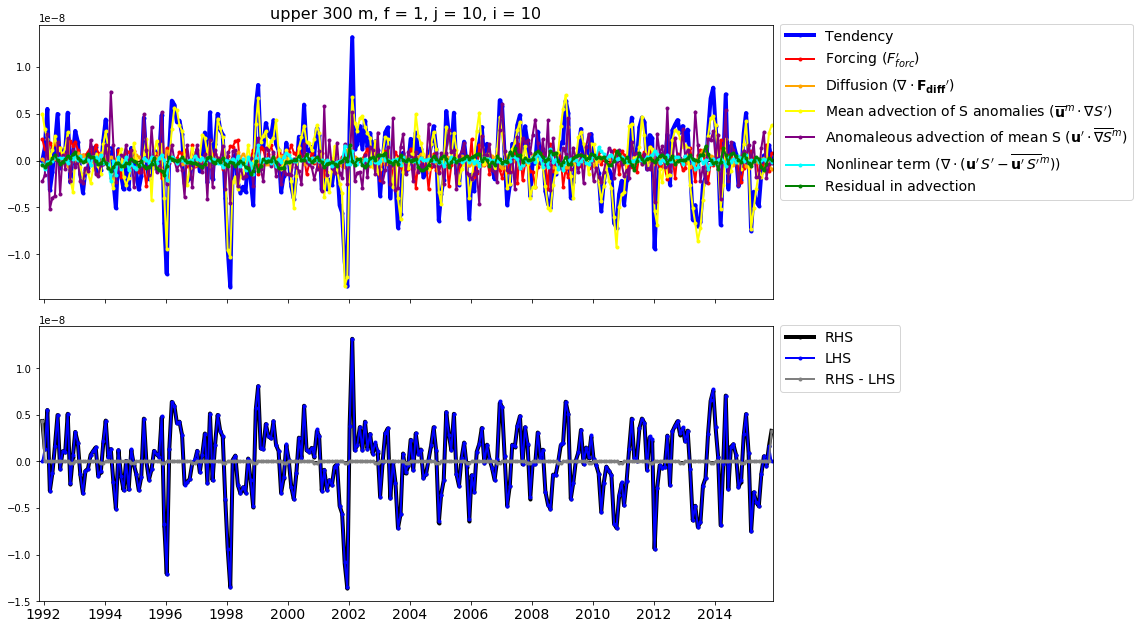

In [90]:
fig, axes = plt.subplots(2, 1,figsize=(17,10))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.title('upper %s m, f = %s, j = %s, i = %s' % (z_lower,f,j,i), fontsize=16)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time, results[0], lw=4, color='blue', marker='.',label='Tendency')
plt.plot(results[1].time, results[1], lw=2, color='red', marker='.',
         label=r'Forcing ($F_{forc}^{\prime}$)')
plt.plot(results[2].time, results[2], lw=2, color='orange', marker='.',
         label=r'Diffusion ($\nabla \cdot {\mathbf{F_{diff}}}^{\prime}$)')
plt.plot(results[3].time, results[3], lw=2, color='yellow', marker='.',
         label=r'Mean advection of S anomalies ($\overline{\mathbf{u}}^m\cdot\nabla S^{\prime}$)')
plt.plot(results[4].time, results[4], lw=2, color='purple', marker='.',
         label=r'Anomaleous advection of mean S ($\mathbf{u}^{\prime} \cdot \overline{\nabla S}^m$)')
plt.plot(results[5].time, results[5], lw=2, color='cyan', marker='.',
         label=r'Nonlinear term ($\nabla \cdot ({\mathbf{u}}^{\prime}\,S^{\prime}-\overline{\mathbf{u}^{\prime}\,S^{\prime}}^m)$)')
plt.plot(results[6].time, results[6], lw=2, color='green', marker='.',label='Residual in advection')
#plt.xlim([ds_budgH_anom.time.values[0],ds_budgH_anom.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'))
#plt.yticks(np.arange(-4e-7,6e-7,2.0e-7),fontsize=14)
plt.setp(plt.gca(), 'xticklabels',[])
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

plt.subplot(2, 1, 2)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(total.time, total, lw=4, color='k', marker='.',label='RHS')
plt.plot(results[0].time, results[0], lw=2, color='blue', marker='.',label='LHS')
plt.plot(results[0].time, total-results[0], lw=2, color='grey', marker='.',label='RHS - LHS')
#plt.xlim([ds_budgH_anom.time.values[0],ds_budgH_anom.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'),fontsize=14)
#plt.yticks(np.arange(-4e-7,6e-7,2.0e-7),fontsize=14)

plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

fig.subplots_adjust(left=0.1, right=0.7, bottom=0.1, top=0.9)

#plt.savefig('/rigel/home/jt2796/tmp/figure.png')
plt.show()

In [91]:
df = pd.DataFrame({'Tendency':results[0].isel(time=slice(1, -1)),'Forcing':results[1].isel(time=slice(1, -1)),
                   'Diffusion':results[2].isel(time=slice(1, -1)),'ubarSanom':results[3].isel(time=slice(1, -1)),
                   'uanomSbar':results[4].isel(time=slice(1, -1)),'Nonlinear':results[5].isel(time=slice(1, -1)),
                   'Residual':results[6].isel(time=slice(1, -1))})

In [92]:
for col in list(df):
    var = np.var(df.Tendency,ddof=1)
    cov = np.cov(df[col], df.Tendency)[0][1]
    ratio = cov/var
    print (col, '%.2f' % ratio)

Tendency 1.00
Forcing -0.01
Diffusion -0.01
ubarTanom 0.74
uanomTbar 0.25
Nonlinear 0.01
Residual 0.01


In [93]:
-0.01-0.01+0.74+0.25+0.01+0.01

0.99

In [94]:
ds_budgSln_anom_aveZ_intT = (ds_budgSln_anom_aveZ.isel(time=slice(1, -1))\
                           *coords_budg.dt.isel(time=slice(1, -1))).cumsum(dim='time')

ds_budgSln_anom_aveZ_intT['time'] = coords_main.isel(time=slice(1, -1)).time

In [95]:
results = dask.compute(ds_budgSln_anom_aveZ_intT.tendSln_anom[:,f,j,i],
                       ds_budgSln_anom_aveZ_intT.forcSln_anom[:,f,j,i], 
                       ds_budgSln_anom_aveZ_intT.dif_ConvSln_anom[:,f,j,i],
                       ds_budgSln_anom_aveZ_intT.adv_ConvSln_Uclim_Sanom[:,f,j,i], 
                       ds_budgSln_anom_aveZ_intT.adv_ConvSln_Uanom_Sclim[:,f,j,i],
                       ds_budgSln_anom_aveZ_intT.adv_ConvSln_Uanom_Sanom[:,f,j,i],
                       ds_budgSln_anom_aveZ_intT.adv_ConvSln_res_anom[:,f,j,i])

/rigel/home/jt2796/dask/dask/local.py:255: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/rigel/home/jt2796/dask/dask/local.py:255: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


In [96]:
total = results[1] + results[2] + results[3] + results[4] + results[5] + results[6]

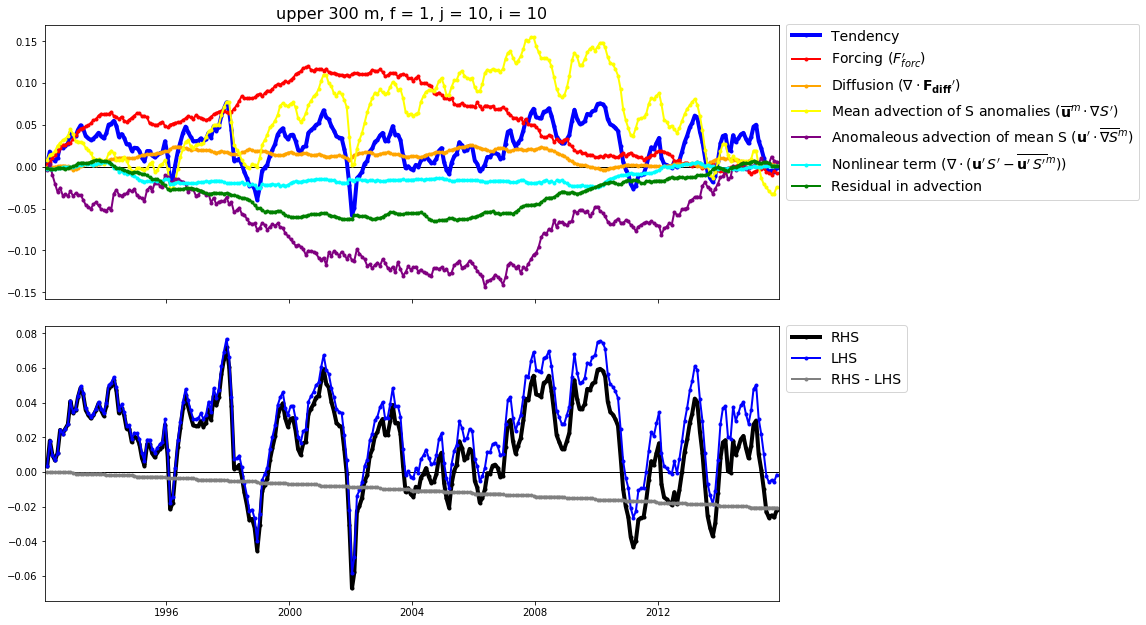

In [97]:
fig, axes = plt.subplots(2, 1,figsize=(12,10))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.title('upper %s m, f = %s, j = %s, i = %s' % (z_lower,f,j,i), fontsize=16)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time, results[0], lw=4, color='blue', marker='.',label='Tendency')
plt.plot(results[1].time, results[1], lw=2, color='red', marker='.',
         label=r'Forcing ($F_{forc}^{\prime}$)')
plt.plot(results[2].time, results[2], lw=2, color='orange', marker='.',
         label=r'Diffusion ($\nabla \cdot {\mathbf{F_{diff}}}^{\prime}$)')
plt.plot(results[3].time, results[3], lw=2, color='yellow', marker='.',
         label=r'Mean advection of S anomalies ($\overline{\mathbf{u}}^m\cdot\nabla S^{\prime}$)')
plt.plot(results[4].time, results[4], lw=2, color='purple', marker='.',
         label=r'Anomaleous advection of mean S ($\mathbf{u}^{\prime} \cdot \overline{\nabla S}^m$)')
plt.plot(results[5].time, results[5], lw=2, color='cyan', marker='.',
         label=r'Nonlinear term ($\nabla \cdot ({\mathbf{u}}^{\prime}\,S^{\prime}-\overline{\mathbf{u}^{\prime}\,S^{\prime}}^m)$)')
plt.plot(results[6].time, results[6], lw=2, color='green', marker='.',label='Residual in advection')
plt.xlim([ds_budgSln_anom.time.values[0],ds_budgSln_anom.time.values[-1]])
plt.setp(plt.gca(), 'xticklabels',[])
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

plt.subplot(2, 1, 2)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(total.time, total, lw=4, color='k', marker='.',label='RHS')
plt.plot(results[0].time, results[0], lw=2, color='blue', marker='.',label='LHS')
plt.plot(results[0].time, total-results[0], lw=2, color='grey', marker='.',label='RHS - LHS')
plt.xlim([ds_budgSln_anom.time.values[0],ds_budgSln_anom.time.values[-1]])
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.9)
plt.show()

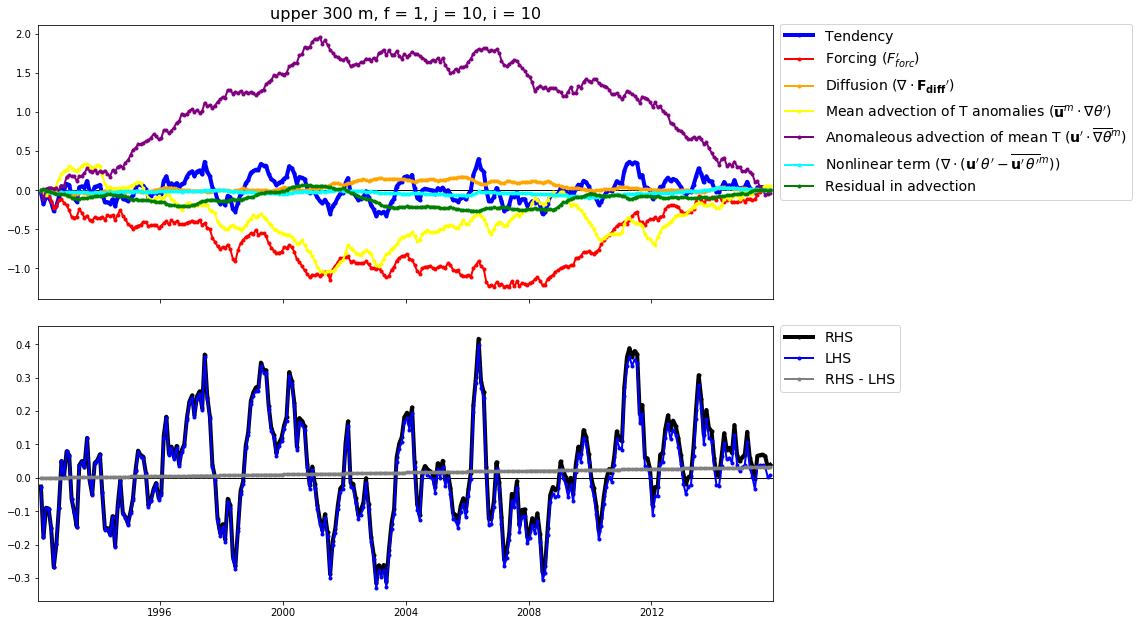

In [98]:
df = pd.DataFrame({'Tendency':results[0].isel(time=slice(1, -1)),'Forcing':results[1].isel(time=slice(1, -1)),
                   'Diffusion':results[2].isel(time=slice(1, -1)),'ubarSanom':results[3].isel(time=slice(1, -1)),
                   'uanomSbar':results[4].isel(time=slice(1, -1)),'Nonlinear':results[5].isel(time=slice(1, -1)),
                   'Residual':results[6].isel(time=slice(1, -1))})

In [99]:
for col in list(df):
    var = np.var(df.Tendency,ddof=1)
    cov = np.cov(df[col], df.Tendency)[0][1]
    ratio = cov/var
    print (col, '%.5f' % ratio)

Tendency 1.00000
Forcing -0.17391
Diffusion -0.02895
ubarSanom 0.92742
uanomSbar 0.19320
Nonlinear -0.02088
Residual 0.10638


In [100]:
-0.17391-0.02895+0.92742+0.19320-0.02088+0.10638

1.00326

In [101]:
for col in list(df):
    corr = stats.linregress(df[col], df.Tendency)[2]**2
    print (col, '%.2f' % corr)

Tendency 1.00
Forcing 0.01
Diffusion 0.01
ubarSanom 0.23
uanomSbar 0.01
Nonlinear 0.00
Residual 0.01
